In [ ]:
  # Faster rcnn based multi task. netwok. 
  # At first it detects objects from image
  # then another classification cnn run on that image with same feature
  # feature extractor is ROIPolling layer
  # currently have no dataset to train the last classification model
  # everystep done except dataset

In [1]:
!pip install git+https://github.com/google-research/tf-slim

  Cloning https://github.com/google-research/tf-slim to /tmp/pip-req-build-s2z_jsqi
  Running command git clone -q https://github.com/google-research/tf-slim /tmp/pip-req-build-s2z_jsqi
  Created wheel for tf-slim: filename=tf_slim-1.2.0-cp36-none-any.whl size=360911 sha256=0c885ae26a01aa07df7d2bec36698ee6a0ba3576eebe4aa76cc517552bfdea59
  Stored in directory: /tmp/pip-ephem-wheel-cache-sdamf_va/wheels/bb/98/dc/eba6500d756d16f6ff371b39ed733d26cec1b0b0085e1cb0df
Successfully built tf-slim


In [2]:
!pip install -U --pre tensorflow=="2.*"
!pip install pycocotools


Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.3.0)


In [3]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models


Cloning into 'models'...
remote: Enumerating objects: 2017, done.
remote: Counting objects: 100% (2017/2017), done.
remote: Compressing objects: 100% (1755/1755), done.
remote: Total 2017 (delta 459), reused 882 (delta 239), pack-reused 0
Receiving objects: 100% (2017/2017), 30.20 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (459/459), done.


In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.


In [5]:
%%bash
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1328004 sha256=3da1dc060c68893f27e0ec765f6b16c7ec08b48491ec80925c16587d27b3e36a
  Stored in directory: /tmp/pip-ephem-wheel-cache-scjgrxr7/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [7]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [8]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [9]:
#@title
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ROIPoolingLayer(Layer):
    """ Implements Region Of Interest Max Pooling 
        for channel-first images and relative bounding box coordinates
        
        # Constructor parameters
            pooled_height, pooled_width (int) -- 
              specify height and width of layer outputs
        
        Shape of inputs
            [(batch_size, pooled_height, pooled_width, n_channels),
             (batch_size, num_rois, 4)]
           
        Shape of output
            (batch_size, num_rois, pooled_height, pooled_width, n_channels)
    
    """
    def __init__(self, pooled_height, pooled_width, **kwargs):
        self.pooled_height = pooled_height
        self.pooled_width = pooled_width
        
        super(ROIPoolingLayer, self).__init__(**kwargs)
        
    def compute_output_shape(self, input_shape):
        """ Returns the shape of the ROI Layer output
        """
        feature_map_shape, rois_shape = input_shape
        assert feature_map_shape[0] == rois_shape[0]
        batch_size = feature_map_shape[0]
        n_rois = rois_shape[1]
        n_channels = feature_map_shape[3]
        return (batch_size, n_rois, self.pooled_height, 
                self.pooled_width, n_channels)

    def call(self, x):
        """ Maps the input tensor of the ROI layer to its output
        
            # Parameters
                x[0] -- Convolutional feature map tensor,
                        shape (batch_size, pooled_height, pooled_width, n_channels)
                x[1] -- Tensor of region of interests from candidate bounding boxes,
                        shape (batch_size, num_rois, 4)
                        Each region of interest is defined by four relative 
                        coordinates (x_min, y_min, x_max, y_max) between 0 and 1
            # Output
                pooled_areas -- Tensor with the pooled region of interest, shape
                    (batch_size, num_rois, pooled_height, pooled_width, n_channels)
        """
        def curried_pool_rois(x): 
          return ROIPoolingLayer._pool_rois(x[0], x[1], 
                                            self.pooled_height, 
                                            self.pooled_width)
        
        pooled_areas = tf.map_fn(curried_pool_rois, x, dtype=tf.float32)

        return pooled_areas
    
    @staticmethod
    def _pool_rois(feature_map, rois, pooled_height, pooled_width):
        """ Applies ROI pooling for a single image and varios ROIs
        """
        def curried_pool_roi(roi): 
          return ROIPoolingLayer._pool_roi(feature_map, roi, 
                                           pooled_height, pooled_width)
        
        pooled_areas = tf.map_fn(curried_pool_roi, rois, dtype=tf.float32)
        return pooled_areas
    
    @staticmethod
    def _pool_roi(feature_map, roi, pooled_height, pooled_width):
        """ Applies ROI pooling to a single image and a single region of interest
        """

        # Compute the region of interest        
        feature_map_height = int(feature_map.shape[0])
        feature_map_width  = int(feature_map.shape[1])
        
        h_start = tf.cast(feature_map_height * roi[0], 'int32')
        w_start = tf.cast(feature_map_width  * roi[1], 'int32')
        h_end   = tf.cast(feature_map_height * roi[2], 'int32')
        w_end   = tf.cast(feature_map_width  * roi[3], 'int32')
        
        region = feature_map[h_start:h_end, w_start:w_end, :]
        
        # Divide the region into non overlapping areas
        region_height = h_end - h_start
        region_width  = w_end - w_start
        h_step = tf.cast( region_height / pooled_height, 'int32')
        w_step = tf.cast( region_width  / pooled_width , 'int32')
        
        areas = [[(
                    i*h_step, 
                    j*w_step, 
                    (i+1)*h_step if i+1 < pooled_height else region_height, 
                    (j+1)*w_step if j+1 < pooled_width else region_width
                   ) 
                   for j in range(pooled_width)] 
                  for i in range(pooled_height)]
        
        # take the maximum of each area and stack the result
        def pool_area(x): 
          return tf.math.reduce_max(region[x[0]:x[2], x[1]:x[3], :], axis=[0,1])
        
        pooled_features = tf.stack([[pool_area(x) for x in row] for row in areas])
        return pooled_features

In [10]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [11]:
from os import listdir
def load_model(model_name,link):
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=link,
    untar=True)


  model_dir = pathlib.Path(model_dir)/"saved_model"
  print(model_dir)
  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [12]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [13]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/15652609_500_B.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/1585864356-1_798d77e0-a3db-412e-9acf-5006970e6a75.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/2bbbc55c216f9109ce0e7de72427a056.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/4876f9d2d73d08f9642148a84b188622.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/74e3391c26c67bed9a0728f518a1db7c.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/809256.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/Cool-Casual-Men-Plain-T-shirt-Outfits-Ideas-39.jpg'),
 PosixPath('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train/Free-

In [14]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
link = 'http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz'
detection_model = load_model(model_name,link)

149127168/149119618 [==============================] - 3s 0us/step
/root/.keras/datasets/faster_rcnn_inception_v2_coco_2018_01_28/saved_model
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
detection_model.function_def

In [16]:
detection_model.output_dtypes

In [17]:
detection_model.output_shapes

In [18]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [19]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
#   print(output_dict)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))
  return output_dict;


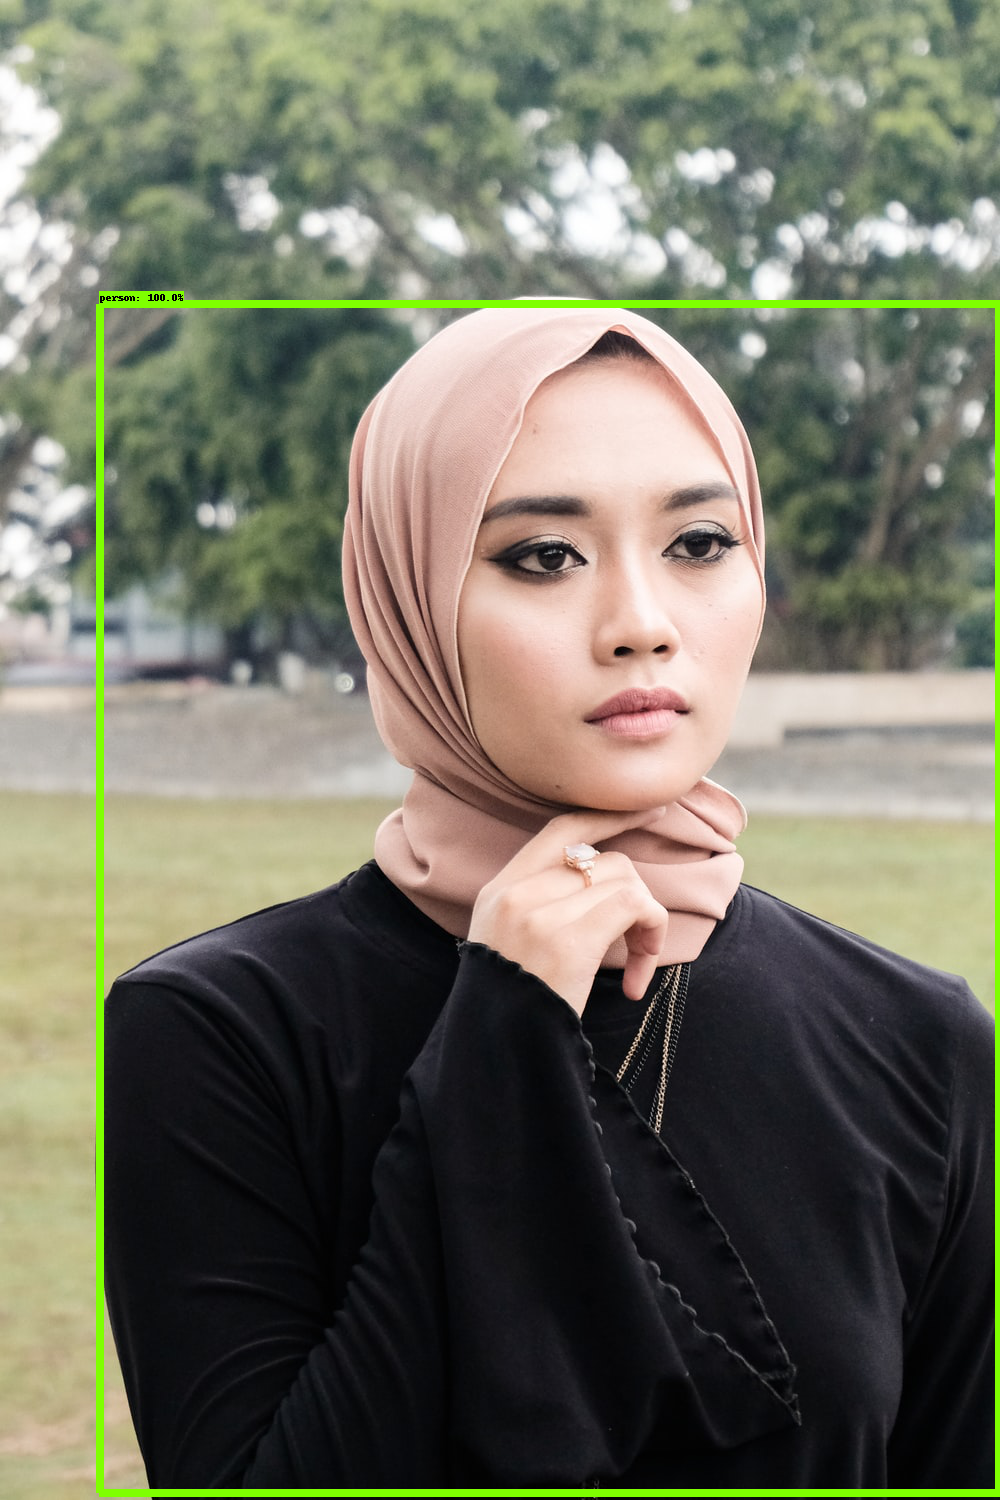

In [28]:
for image_path in TEST_IMAGE_PATHS:
    out = show_inference(detection_model, '/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/test/hijab.jpg')
    break



```
# This is formatted as code
```

From HERE TRAINING

In [29]:
import keras
from keras import layers

inputs = keras.Input(name='input',shape=(3,3,2048))
x = layers.GlobalAveragePooling2D(name='avg')(inputs)
x = layers.Dropout(0.5,name='dropout')(x)
gender = layers.Dense(2, activation= 'softmax',name='gender')(x)
hair = layers.Dense(2, activation= 'softmax',name='hair')(x)

model = keras.Model(inputs=inputs, outputs=[gender,hair],name = 'clasifier')

model.summary()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


Model: "clasifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 3, 3, 2048)] 0                                            
__________________________________________________________________________________________________
avg (GlobalAveragePooling2D)    (None, 2048)         0           input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           avg[0][0]                        
__________________________________________________________________________________________________
gender (Dense)                  (None, 2)            4098        dropout[0][0]                    
__________________________________________________________________________________________

In [30]:
resnet50FeatureModel =  keras.applications.ResNet50( include_top=False,
                                                        weights="imagenet",
                                                        input_tensor=None,
                                                        input_shape=None,
                                                        pooling=max,
                                                        classes=1000
                                                    )

In [ ]:
def get_train_data(model, image_path):
 
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
#   print(output_dict)
  # Visualization of the results of a detection.
  dectect= []
  for i,output in enumerate(output_dict['detection_classes']):
    #   print(i,output)
      if output==1 and output_dict['detection_scores'][i]>.80:
          detect = np.array([output_dict['detection_boxes'][i]])
          break
  
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  display(Image.fromarray(image_np))
  return np.array([detect]);

In [ ]:
def extractfeature(img,FeatureModel):
    return FeatureModel.predict(np.array([image_np]))

to do future.. train with same size_image.. resize image before get box and feature

In [ ]:
import pickle
from google.colab import output

PATH_TO_TRAIN_IMAGES_DIR = pathlib.Path('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/Train')
TRAIN_IMAGE_PATHS = sorted(list(PATH_TO_TRAIN_IMAGES_DIR.glob("*.jpg"))\
                           +list(PATH_TO_TRAIN_IMAGES_DIR.glob("*.jpeg"))\
                           +list(PATH_TO_TRAIN_IMAGES_DIR.glob("*.png")))
for img_path in TRAIN_IMAGE_PATHS:
    #get bounding box and classification
    txt_file_path = os.path.splitext(img_path)[0]+'.txt';
    print(img_path)
    # continue;
    if not os.path.isfile(txt_file_path):
        output.clear()
        box = get_train_data(detection_model, img_path)
        gender = int(input('gender(1/0)'))
        hair = int(input('hair(1/0)'))
        # body = int(input('person body color(1/0)'))
        # l = [box,np.array([gender,hair,body])]
        image_np = np.array(Image.open(img_path))
        image_np = image_np.astype('float32')/255.0
        feature = extractfeature(image_np,resnet50FeatureModel)
        roi_layer = ROIPoolingLayer(3,3)
        x = box[0][0]
        x = [x[1],x[0],x[3],x[2]]
        box[0][0] = x
        result = roi_layer([feature,box])
        print(box)
        print(result[0])
        with open(txt_file_path, "wb") as fp:
            pickle.dump([result,np.array([gender,hair])], fp)


In [ ]:
X = []
Y = []
Z = []
for img_path in TRAIN_IMAGE_PATHS:
    # print(img_path)
    txt_file_path = os.path.splitext(img_path)[0]+'.txt';
    with open(txt_file_path, "rb") as fp:
        inputs,labels = pickle.load(fp)
    labels = labels.astype('uint8')
    # print(inputs.shape)
    g = keras.utils.to_categorical(labels[0], num_classes=2, dtype="float32")
    h = keras.utils.to_categorical(labels[1], num_classes=2, dtype="float32")
    # b = keras.utils.to_categorical(labels[2], num_classes=2, dtype="float32")
    # g = np.array([g])
    # h = np.array([h])
    # b = np.array([b])
    # print(g,h,b)
    # model.fit(inputs[0].numpy(),{'gender':g,'hair':h},epochs=1,verbose=0)
    x = inputs[0].numpy()
    X.append(x[0])
    Y.append(g)
    Z.append(h)

Z = np.array(Z)
Y = np.array(Y)


In [ ]:
force stop

train__load model.. don't run all it will upadate weight

In [31]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/classifier.h5')

In [ ]:
model.fit(np.array(X),{'gender':Y,'hair':Z},epochs=5)

In [ ]:
model.save('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/classifier.h5')

Predicting frome here

In [32]:
def get_test_data(model, image_path):
 
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
#   print(output_dict)
  # Visualization of the results of a detection.
  detect = {"detection_classes":[],"detection_scores":[],"detection_boxes":[]}
  for i,output in enumerate(output_dict['detection_classes']):
    #   print(i,output)
      if output==1 and output_dict['detection_scores'][i]>.90:
            detect["detection_classes"].append(output_dict['detection_classes'][i])
            detect['detection_scores'].append(output_dict['detection_scores'][i])
            detect['detection_boxes'].append(output_dict['detection_boxes'][i])
#   print(output_dict)
#   print(detect)
  detect["detection_classes"] = np.array(detect["detection_classes"])
  detect['detection_scores'] = np.array(detect['detection_scores'])
  detect['detection_boxes'] = np.array(detect['detection_boxes'])
#   vis_util.visualize_boxes_and_labels_on_image_array(
#       image_np,
#       detect['detection_boxes'],
#       detect['detection_classes'],
#       detect['detection_scores'],
#       category_index,
#       instance_masks=output_dict.get('detection_masks_reframed', None),
#       use_normalized_coordinates=True,
#       line_thickness=1)
#   display(Image.fromarray(image_np))
  return np.array([detect['detection_boxes']]);

In [33]:
%matplotlib inline
def func(image):
    plt.figure(figsize=(15,10))
    plt.imshow(img/255.0)
    plt.show()

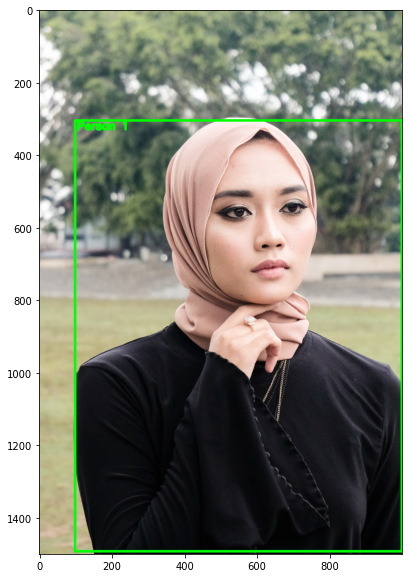

Person 1 is women and is wearing hijab


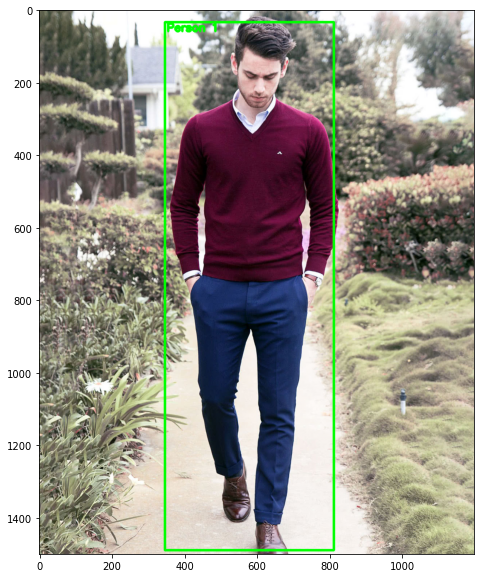

Person 1 is women and is wearing hijab


KeyboardInterrupt: ignored

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/drive/My Drive/practical(Needed)/python/TFasterRCNN/data/images/test')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg"))\
                           +list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpeg"))\
                           +list(PATH_TO_TEST_IMAGES_DIR.glob("*.png")))
label = {0:'men',1:'women'}
label2 = {0:'not wearing hijab',1:'wearing hijab'}
for img_path in TEST_IMAGE_PATHS:
    box = get_test_data(detection_model, img_path)
    image_np = np.array(Image.open(img_path))
    img = image_np.copy()
    image_np = image_np.astype('float32')/255.0
    height,width,_ = image_np.shape
    listxy = []
    for i,b in enumerate(box[0]):
        xmin = int(b[1]*width)
        ymin = int(b[0]*height)
        xmax = int(b[3]*width)
        ymax = int(b[2]*height)
        
        box[0][i] = b[1],b[0],b[3],b[2]
        s = 'Person '+str(i+1)
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(0,255,0),5)
        cv2.putText(img, s, (xmin+5, ymin+25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 5)



    # plt.imshow(image_np)
    func(img)

    feature = extractfeature(image_np,resnet50FeatureModel)
    roi_layer = ROIPoolingLayer(3,3)
    result = roi_layer([feature,box])

    for i,res in enumerate(result[0]):
        resnp = np.array([res.numpy()])
        pred = model.predict(resnp)
        x = int(np.argmax(pred[0]))
        y = int(np.argmax(pred[1]))
        s = f'Person {i+1} is {label[x]} and is {label2[y]}'
        print(s)

